In [1]:
## Imports
from typing import Dict, List
from pathlib import Path
import sys

sys.path.append("..")

import numpy as np

# Use the pgf backend (must be set before pyplot imported) -- once set `plt.show()` doesn't work
import matplotlib as mpl

eng = "pdf"  # no issue here
mpl.use("pgf")
mpl.rc("font", family="serif")
mpl.rcParams.update(
    {
        "pgf.rcfonts": False,
        "pgf.texsystem": eng + "latex",
        # "pgf.preamble" : '\\usepackage[utf8x]{inputenc}\\usepackage[light]{kpfonts}',
    }
)

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import torch

from utils.train_utils import get_data, get_model

In [2]:
## Simulate the args like in the `main_*.py` files
class ARGS:
    # federated arguments
    # epochs:int = 1000         # rounds of training
    epochs: int = 10  # rounds of training
    train_test_same: int = 0  # use same testing for
    num_users: int = 100  # number of users: K
    shard_per_user: int = 2  # classes per user
    frac: float = 0.1  # the fraction of clients: C
    local_ep: int = 1  # the number of local epochs: E
    local_bs: int = 10  # local batch size: B
    bs: int = 128  # test batch size
    lr: float = 0.01  # learning rate
    # results_save:str = "run1"
    momentum: float = 0.5  # SGD momentum (default: 0.5)
    # gpu:int = 0
    split: str = "user"  # train-test split type, user or sample
    # grad_norm:str           # use_gradnorm_avging
    local_ep_pretrain: int = 0  # the number of pretrain local ep
    lr_decay: float = 1.0  # learning rate decay per round

    # model arguments
    model: str = "cnn"  # model name
    kernel_num: int = 9  # number of each kind of kernel
    kernel_sizes: str = "3,4,5"  # comma-separated kernel size to use for convolution
    norm: str = "batch_norm"  # batch_norm, layer_norm, or None
    num_filters: int = 32  # number of filters for conv nets
    max_pool: str = True  # whether use max pooling rather than strided convolutions
    num_layers_keep: int = 1  # number layers to keep

    # other arguments
    dataset: str = "coba"  # name of dataset
    log_level: str = "warning"  # level of logger
    iid: bool = True  # "store_true" #whether iid or not
    num_classes: int = 14  # number of classes
    num_channels: int = 3  # number of channels of images RGB
    gpu: int = 0  # GPU ID, -1 for CPU
    stopping_rounds: int = 10  # rounds of early stopping
    verbose: bool = True  # "store_true"
    print_freq: int = 100  # print loss frequency during training
    seed: int = 1  # random seed (default:1)
    test_freq: int = 1  # how often to test on val set
    load_fed: str = ""  # define pretrained federated model path
    results_save: str = "run1"  # define fed results save folder
    start_saving: int = 0  # when to start saving models


args = ARGS()

args.device = torch.device(
    "cuda:{}".format(args.gpu)
    if torch.cuda.is_available() and args.gpu != -1
    else "cpu"
)

args.num_users, args.device

(100, device(type='cuda', index=0))

## CIFAR10

In [3]:
args.dataset = "cifar10"
args.iid = False
args.model = "cnn"
args.num_classes = 10
# args.dataset = "mnist"

In [4]:
dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

model = get_model(args)

model_state_dict_path: str = Path(
    "../save",
    args.dataset,
    "cnn_iidFalse_num100_C0.3_le1",
    "shard2",
    "seed10_cifar10_fedavg_bestcase_run1",
    "fed",
    "model_1000.pt",
)

model.load_state_dict(
    torch.load(model_state_dict_path)
) if args.device.type != "cpu" else model.load_state_dict(
    torch.load(model_state_dict_path, map_location=torch.device("cpu"))
)

Files already downloaded and verified
Files already downloaded and verified
CNNCifar(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


<All keys matched successfully>

In [5]:
data_loader: DataLoader = DataLoader(dataset_test, batch_size=args.bs)
IS_USING_GPU: bool = args.gpu != -1 and args.device.type != "cpu"

y_preds: np.array = np.array([])
y_trues: np.array = np.array([])
# coba_cms = []

for _, (data, target) in enumerate(data_loader):
    if args.gpu != -1 and args.device.type != "cpu":
        data, target = data.to(args.device), target.to(args.device)
    if args.dataset == "coba":
        data = data.permute(0, 3, 1, 2)

    log_probs: torch.Tensor = model(data)

    y_pred: torch.Tensor = (
        log_probs.cpu().data.max(1, keepdim=True)[1]
        if args.device.type != "cpu"
        else log_probs.data.max(1, keepdim=True)[1]
    )

    y_true: torch.Tensor = (
        torch.tensor(list(map(torch.argmax, target.data)), device="cpu").data.view_as(
            y_pred
        )
        if args.dataset == "coba"
        else target.to("cpu").data.view_as(y_pred)
    )

    # coba_cms.append(confusion_matrix(y_pred=y_pred,y_true=y_true))

    y_preds = np.append(y_preds, y_pred)
    y_trues = np.append(y_trues, y_true)

y_preds.shape == y_trues.shape

True

In [7]:
CUSTOM_COLORBAR: bool = True
plt.clf()

cm = confusion_matrix(y_pred=y_preds, y_true=y_trues)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[obj_name for obj_name in dataset_train.class_to_idx.keys()],
)
# fig, ax = plt.subplots(figsize=(10,10))
# fig, ax = plt.subplots(figsize=(8,8))
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title(f"{args.dataset.upper()} Confusion Matrix", fontsize=18)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True label", fontsize=15)

if CUSTOM_COLORBAR:
    # Plot Confusion Matrix default colorbar
    disp.plot(ax=ax, xticks_rotation="vertical", colorbar=False)

    # Adding custom colorbar
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    plt.colorbar(disp.im_, cax=cax)
else:
    disp.plot(ax=ax, xticks_rotation="vertical")
    plt.tight_layout()

print(dataset_train.class_to_idx)
# plt.savefig("coba_confusion_matrix_example.png")

save_dir: Path = Path(Path.cwd(), args.dataset)
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(
    Path(save_dir, f"{args.dataset}_confusion_matrix_example.pdf"),
    # format="pdf",
    bbox_inches="tight",
    dpi=300,
)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Check Data Distribution

In [48]:
# class_map:Dict[int,str] = dataset_test.class_to_idx
# class_map:List[int] = list(dataset_test.class_to_idx.values())
class_map: Dict[str, int] = dataset_test.class_to_idx
classes_as_ints: List[int] = [label for _, label in dataset_test]
class_indices, class_counts = np.unique(classes_as_ints, return_counts=True)
class_indices_to_string: List[str] = []
for index in class_indices:
    for class_name, val in class_map.items():
        if index == val:
            class_indices_to_string.append(class_name)
            break

class_indices_to_string, class_counts
# class_map
# for _, label in dataset_test:
#     print(label)
#     break

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

## MNIST

In [8]:
args.dataset = "mnist"
args.iid = False
args.model = "mlp"
args.num_classes = 10
# args.dataset = "mnist"

In [9]:
dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

model = get_model(args)

model_state_dict_path: str = Path(
    "../save",
    args.dataset,
    "mlp_iidFalse_num100_C0.3_le1",
    "shard2",
    "seed0_mnist_fedavg_bestcase_run1",
    "fed",
    "model_1000.pt",
)

model.load_state_dict(
    torch.load(model_state_dict_path)
) if args.device.type != "cpu" else model.load_state_dict(
    torch.load(model_state_dict_path, map_location=torch.device("cpu"))
)

MLP(
  (layer_input): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=512, out_features=256, bias=True)
  (layer_hidden2): Linear(in_features=256, out_features=256, bias=True)
  (layer_hidden3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


<All keys matched successfully>

In [10]:
data_loader: DataLoader = DataLoader(dataset_test, batch_size=args.bs)
IS_USING_GPU: bool = args.gpu != -1 and args.device.type != "cpu"

y_preds: np.array = np.array([])
y_trues: np.array = np.array([])
# coba_cms = []

for _, (data, target) in enumerate(data_loader):
    if args.gpu != -1 and args.device.type != "cpu":
        data, target = data.to(args.device), target.to(args.device)
    if args.dataset == "coba":
        data = data.permute(0, 3, 1, 2)

    log_probs: torch.Tensor = model(data)

    y_pred: torch.Tensor = (
        log_probs.cpu().data.max(1, keepdim=True)[1]
        if args.device.type != "cpu"
        else log_probs.data.max(1, keepdim=True)[1]
    )

    y_true: torch.Tensor = (
        torch.tensor(list(map(torch.argmax, target.data)), device="cpu").data.view_as(
            y_pred
        )
        if args.dataset == "coba"
        else target.to("cpu").data.view_as(y_pred)
    )

    # coba_cms.append(confusion_matrix(y_pred=y_pred,y_true=y_true))

    y_preds = np.append(y_preds, y_pred)
    y_trues = np.append(y_trues, y_true)

y_preds.shape == y_trues.shape

True

In [11]:
CUSTOM_COLORBAR: bool = True
plt.clf()

cm = confusion_matrix(y_pred=y_preds, y_true=y_trues)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[obj_name for obj_name in dataset_train.class_to_idx.keys()],
)
# fig, ax = plt.subplots(figsize=(10,10))
# fig, ax = plt.subplots(figsize=(8,8))
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title(f"{args.dataset.upper()} Confusion Matrix", fontsize=18)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True label", fontsize=15)

if CUSTOM_COLORBAR:
    # Plot Confusion Matrix default colorbar
    disp.plot(ax=ax, xticks_rotation="vertical", colorbar=False)

    # Adding custom colorbar
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    plt.colorbar(disp.im_, cax=cax)
else:
    disp.plot(ax=ax, xticks_rotation="vertical")
    plt.tight_layout()

print(dataset_train.class_to_idx)
# plt.savefig("coba_confusion_matrix_example.png")

save_dir: Path = Path(Path.cwd(), args.dataset)
save_dir.mkdir(exist_ok=True, parents=True)

plt.savefig(
    Path(save_dir, f"{args.dataset}_confusion_matrix_example.pdf"),
    # format="pdf",
    bbox_inches="tight",
    dpi=300,
)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


### Check Data Distribution

In [52]:
class_map: Dict[str, int] = dataset_test.class_to_idx
classes_as_ints: List[int] = [label for _, label in dataset_test]
class_indices, class_counts = np.unique(classes_as_ints, return_counts=True)
class_indices_to_string: List[str] = []
for index in class_indices:
    for class_name, val in class_map.items():
        if index == val:
            class_indices_to_string.append(class_name)
            break

class_indices_to_string, class_counts

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

## COBA

In [12]:
args.dataset = "coba"
args.num_users = 98
args.iid = False
args.model = "cnn"
args.num_classes = 14
# args.dataset = "mnist"

In [13]:
dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

model = get_model(args)

model_state_dict_path: str = Path(
    "../save",
    "coba_legacy",
    "cnn_iidFalse_num98_C0.3_le1",
    "shard2",
    "seed7_coba_fedavg_bestcase_run9",
    "fed",
    "model_1000.pt",
)

model.load_state_dict(
    torch.load(model_state_dict_path)
) if args.device.type != "cpu" else model.load_state_dict(
    torch.load(model_state_dict_path, map_location=torch.device("cpu"))
)

CNNCoba(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=65536, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=14, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


<All keys matched successfully>

In [14]:
data_loader: DataLoader = DataLoader(dataset_test, batch_size=args.bs)
IS_USING_GPU: bool = args.gpu != -1 and args.device.type != "cpu"

y_preds: np.array = np.array([])
y_trues: np.array = np.array([])
# coba_cms = []

for _, (data, target) in enumerate(data_loader):
    if args.gpu != -1 and args.device.type != "cpu":
        data, target = data.to(args.device), target.to(args.device)
    if args.dataset == "coba":
        data = data.permute(0, 3, 1, 2)

    log_probs: torch.Tensor = model(data)

    y_pred: torch.Tensor = (
        log_probs.cpu().data.max(1, keepdim=True)[1]
        if args.device.type != "cpu"
        else log_probs.data.max(1, keepdim=True)[1]
    )

    y_true: torch.Tensor = (
        torch.tensor(list(map(torch.argmax, target.data)), device="cpu").data.view_as(
            y_pred
        )
        if args.dataset == "coba"
        else target.to("cpu").data.view_as(y_pred)
    )

    # coba_cms.append(confusion_matrix(y_pred=y_pred,y_true=y_true))

    y_preds = np.append(y_preds, y_pred)
    y_trues = np.append(y_trues, y_true)

y_preds.shape == y_trues.shape

True

In [15]:
CUSTOM_COLORBAR: bool = True
plt.clf()

cm = confusion_matrix(y_pred=y_preds, y_true=y_trues)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[obj_name for obj_name in dataset_train.class_to_idx.values()],
)
# fig, ax = plt.subplots(figsize=(10,10))
# fig, ax = plt.subplots(figsize=(8,8))
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title(f"{args.dataset.upper()} Confusion Matrix", fontsize=18)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True label", fontsize=15)

if CUSTOM_COLORBAR:
    # Plot Confusion Matrix default colorbar
    disp.plot(ax=ax, xticks_rotation="vertical", colorbar=False)

    # Adding custom colorbar
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    plt.colorbar(disp.im_, cax=cax)
else:
    disp.plot(ax=ax, xticks_rotation="vertical")
    plt.tight_layout()

print(dataset_train.class_to_idx)
# plt.savefig("coba_confusion_matrix_example.png")

save_dir: Path = Path(Path.cwd(), args.dataset)
save_dir.mkdir(exist_ok=True, parents=True)

plt.savefig(
    Path(save_dir, f"{args.dataset}_confusion_matrix_example.pdf"),
    # format="pdf",
    bbox_inches="tight",
    dpi=300,
)

{0: 'airplane', 1: 'ambulance', 2: 'briefcase', 3: 'cannon', 4: 'car', 5: 'civilian', 6: 'dagger', 7: 'dog', 8: 'handgun', 9: 'missilerocket', 10: 'rifle', 11: 'soldier', 12: 'tank', 13: 'truck'}


### Check Data Distribution

In [58]:
class_map: Dict[int, str] = dataset_test.class_to_idx
classes_as_ints: List[int] = [label.argmax().item() for _, label in dataset_test]

# for img,label in coba_dataset:
#     class_index:int = label.argmax().item()
#     classes_as_ints.append(class_index)
# print(class_map[class_index])
# plt.imshow(img)

class_indices, class_counts = np.unique(classes_as_ints, return_counts=True)

coba_class_counts: Dict[str, int] = {
    class_map[class_index]: class_count
    for class_index, class_count in zip(class_indices, class_counts)
}

coba_class_counts

{'airplane': 592,
 'ambulance': 265,
 'briefcase': 175,
 'cannon': 293,
 'car': 1031,
 'civilian': 2748,
 'dagger': 199,
 'dog': 619,
 'handgun': 283,
 'missilerocket': 266,
 'rifle': 587,
 'soldier': 640,
 'tank': 395,
 'truck': 715}

## Visualize Results (COBA)

In [9]:
coba_results_path: str = Path(
    "../save",
    "coba_legacy",
    "cnn_iidFalse_num98_C0.3_le1",
    "shard2",
    "seed10_coba_fedavg_bestcase_run12",
    "fed",
    "results.csv",
)
coba_results_df: pd.DataFrame = pd.read_csv(coba_results_path, delimiter=",")
coba_results_df

,epoch,loss_avg,loss_test,acc_test,f1_test,precision_test,recall_test,best_acc
0,0.0,5.030172,2.588678,31.198910,0.117578,0.077729,0.244540,31.198910
1,1.0,2.226245,2.509014,31.198910,0.117578,0.077729,0.244540,31.198910
2,2.0,2.381672,2.464465,31.198910,0.117578,0.077729,0.244540,31.198910
3,3.0,2.231263,2.430133,31.198910,0.117578,0.077729,0.244540,31.198910
4,4.0,2.143696,2.397084,31.198910,0.117578,0.077729,0.244540,31.198910
...,...,...,...,...,...,...,...,...
995,995.0,0.011996,0.046857,99.125795,0.776697,0.777504,0.776529,99.920527
996,996.0,0.008189,0.039337,99.330154,0.778235,0.778837,0.778105,99.920527
997,997.0,0.092336,0.086895,98.001817,0.767457,0.768901,0.767686,99.920527
998,998.0,0.038456,0.067097,98.694369,0.773439,0.774820,0.773138,99.920527


In [10]:
coba_results_df.describe()

,epoch,loss_avg,loss_test,acc_test,f1_test,precision_test,recall_test,best_acc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,0.345473,0.863734,71.569267,0.553706,0.590254,0.560634,75.217711
std,288.819436,0.746869,0.831901,28.084318,0.230352,0.201873,0.219981,25.249273
min,0.000000,0.002734,0.011604,9.230245,0.025715,0.027763,0.072275,31.198910
25%,249.750000,0.024524,0.084107,41.885218,0.323443,0.416577,0.328247,46.821072
50%,499.500000,0.128729,0.520709,83.503633,0.653754,0.679631,0.654051,88.578565
75%,749.250000,0.572703,1.701580,98.098320,0.768840,0.770606,0.768481,98.776680
max,999.000000,20.007770,2.588678,99.920527,0.782749,0.782780,0.782758,99.920527


In [11]:
args.num_users = 98
args.frac = "0.3"
args.iid = False
args.log_level = "info"  # "debug" might crash the notebook
args.seed = 0
args.results_save = "coba_fedavg_bestcase_run2"

base_dir: Path = Path(
    Path.cwd().parent,
    "save",
    "coba_legacy",
    f"{args.model}_iid{args.iid}_num{args.num_users}_C{args.frac}_le{args.local_ep}",
    f"shard{args.shard_per_user}",
)


base_dir = Path(base_dir, f"seed{args.seed}_{args.results_save}")
base_dir

PosixPath('/home/tank/Coding-Practice/objective3-fl-experiment/dynamic-model-selection-for-async-fl/save/coba_legacy/cnn_iidFalse_num98_C0.3_le1/shard2/seed0_coba_fedavg_bestcase_run2')

In [ ]:
from utils.train_utils import save_metrics_graphs

save_metrics_graphs(base_dir=base_dir, df=coba_results_df)

In [29]:
import matplotlib as mpl

# import matplotlib.pyplot as plt


def graph_adjusted(base_dir: Path, col_name: str, df: pd.DataFrame) -> None:
    graphs_dir: Path = Path(base_dir, "fed", "metrics_graphs")
    graphs_dir.mkdir(exist_ok=True)

    graph_save_file: Path = Path(graphs_dir, f"{col_name.title()}.png")

    adjusted_col = (
        df.groupby(np.arange(len(df)) // 10).mean()[col_name].values
    )  # averaged every 10 epochs
    epochs = np.arange(len(df) // 10) * 10

    sns.set_style("ticks", {"grid.linestyle": "-."})
    # sns.set_style("dark", {"grid.color":"0.6","grid.linestyle":"-."})

    fig, ax = plt.subplots(figsize=(5, 5))
    # fig, ax = plt.subplots(figsize=(8, 8))

    # graph line (0.3 opacity)
    sns.lineplot(
        x=epochs,
        y=adjusted_col,
        hue=["best"] * len(epochs),
        palette=sns.color_palette("Dark2", n_colors=1),
        legend=True,
        alpha=0.7,
        ax=ax,
    ).set(
        title=col_name.title(),
        xlabel="Epochs",
        ylabel="Value",
    )

    # graph markers (no opacity)
    lineplot_markers = sns.lineplot(
        x=epochs,
        y=adjusted_col,
        # markers=True,
        marker="d",
        # marker="v",
        # marker="P",
        # dashes=False,
        markersize=4,
        markerfacecolor=sns.color_palette("Dark2", n_colors=1)[0],
        legend=True,
        linestyle="",
        alpha=1,
        ax=ax,
    )
    plt.legend(frameon=True, framealpha=1).get_frame().set_facecolor("white")

    for handler in lineplot_markers.legend_.legend_handles:
        handler.set_marker("d")

    # for dots in lineplot:
    #     color = dots.get_facecolor()
    #     dots.set_color(sns.set_hls_values(color, l=0.5))
    #     dots.set_alpha(1)
    # for line in lineplot.lines:
    #     line.set_zorder(0)

    plt.grid()
    plt.show()
    # plt.savefig(graph_save_file)
    # plt.clf()

In [30]:
graph_adjusted(col_name="best_acc", base_dir=base_dir, df=coba_results_df)

/tmp/ipykernel_7917/3747999255.py:63: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


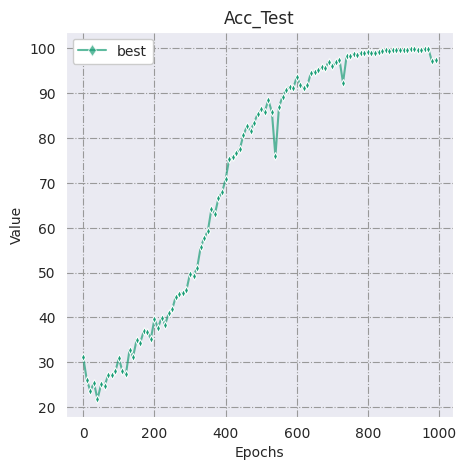

In [405]:
graph_adjusted(col_name="acc_test", base_dir=base_dir, df=coba_results_df)

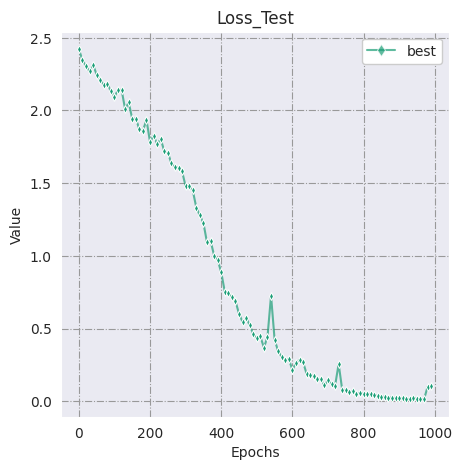

In [406]:
graph_adjusted(col_name="loss_test", base_dir=base_dir, df=coba_results_df)

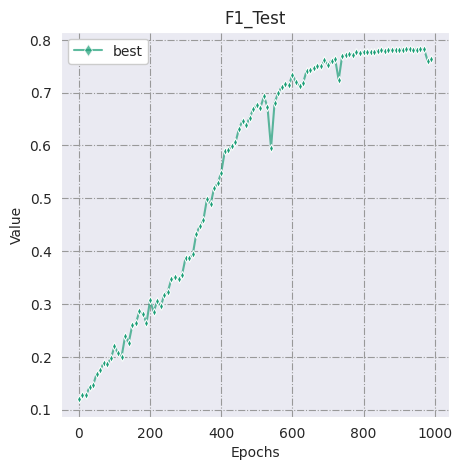

In [407]:
graph_adjusted(col_name="f1_test", base_dir=base_dir, df=coba_results_df)

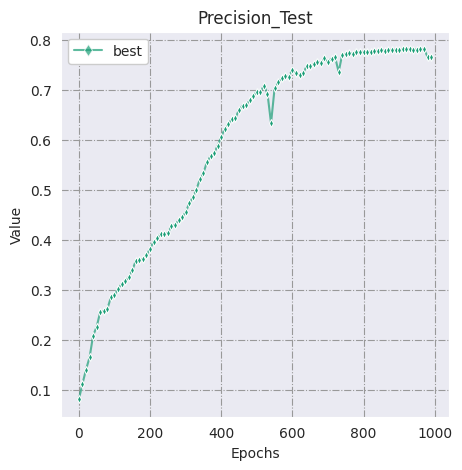

In [408]:
graph_adjusted(col_name="precision_test", base_dir=base_dir, df=coba_results_df)

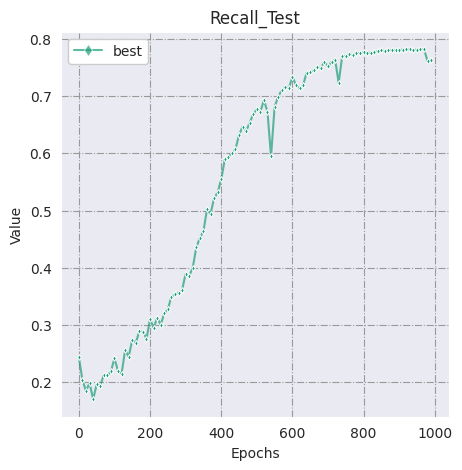

In [402]:
graph_adjusted(
    col_name="recall_test",
    base_dir=base_dir,
    df=coba_results_df,
)